# Code from ER class

In [25]:
import scipy as sp
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
# import networkx as nx

ImportError: cannot import name '_dispatch' from 'networkx.classes' (/usr/lib/python3/dist-packages/networkx/classes/__init__.py)

Let's compare the memory usage between a sparse and a normal matrix.
Moreover, we assume a microcanonical ensemble, fixing the number of nodes and links.

In [19]:
Nnode = int(1e3)
Nlink = int(3e4)
Net1 = sp.sparse.lil_matrix((Nnode,Nnode))
Net2 = np.zeros((Nnode,Nnode))

print(sys.getsizeof(Net1))
print(sys.getsizeof(Net2))

48
8000128


## Microcanonical ensemble

Now, let's try to generate a random graph without using Networkx functions.

In [20]:
for index in range(100):
    # generate a random link
    ii = np.random.randint(Nnode, size=(Nlink, 2))
    # create a sparse matrix using these links
    NetM = sp.sparse.coo_matrix((np.ones(Nlink), (ii[:,0], ii[:,1])), shape=(Nnode, Nnode))
    #remove loops
    NetM.setdiag(0)
    # symmetrize
    NetM = NetM + NetM.T
print(NetM)

  (0, 29)	1.0
  (0, 33)	1.0
  (0, 36)	1.0
  (0, 79)	1.0
  (0, 86)	1.0
  (0, 98)	1.0
  (0, 151)	1.0
  (0, 167)	1.0
  (0, 172)	1.0
  (0, 177)	1.0
  (0, 182)	1.0
  (0, 202)	1.0
  (0, 219)	1.0
  (0, 222)	1.0
  (0, 226)	1.0
  (0, 254)	1.0
  (0, 262)	1.0
  (0, 272)	1.0
  (0, 279)	2.0
  (0, 280)	1.0
  (0, 304)	1.0
  (0, 309)	1.0
  (0, 312)	1.0
  (0, 314)	1.0
  (0, 327)	1.0
  :	:
  (999, 535)	1.0
  (999, 625)	1.0
  (999, 632)	1.0
  (999, 642)	1.0
  (999, 644)	1.0
  (999, 663)	1.0
  (999, 677)	1.0
  (999, 698)	1.0
  (999, 728)	1.0
  (999, 735)	1.0
  (999, 738)	1.0
  (999, 748)	1.0
  (999, 782)	1.0
  (999, 790)	1.0
  (999, 814)	1.0
  (999, 819)	1.0
  (999, 852)	1.0
  (999, 857)	1.0
  (999, 894)	1.0
  (999, 916)	1.0
  (999, 922)	1.0
  (999, 959)	1.0
  (999, 962)	1.0
  (999, 985)	1.0
  (999, 986)	1.0


**NOTE** that reciprocal links and repeated links randomly created reduce symmetric links with a probability that scales as $\frac{1}{{Nnode}^2}$

Let's count the number of links in the matrix.

In [21]:
Nl = int(NetM.count_nonzero()/2)
print('Randomly generated links: {:d}'.format(Nl))
print('Missing links for microcanonical ensemble: {:d}'.format(Nlink-Nl))

Randomly generated links: 29091
Missing links for microcanonical ensemble: 909


We notice that we miss some links, then we add one by one missing links until microcanonical constraint fulfilled.

In [22]:
while Nl < Nlink:
    i1 = np.random.randint(Nnode)
    i2 = np.random.randint(Nnode)
    if i1 != i2 and NetM[i1,i2] == 0:
        NetM[i1,i2] = 1
        NetM[i2,i1] = 1 # symmetric link
        Nl += 1

/home/grufoony/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Lastly, let's compute the degree vector, finding minimum and maximum.

In [23]:
K = sum(NetM)
print('Average degree: {:.2f}'.format(np.mean(K)))
print('Minimum degree: {:d}'.format(int(np.min(K))))
print('Maximum degree: {:d}'.format(int(np.max(K))))

Average degree: 61.74
Minimum degree: 39
Maximum degree: 89


## Canonical ensemble

Let's now try to build a canonical ensemble.

In [2]:
Nnode = int(1e2)
Plink = 0.3
Nexp = int(1e4)

In [3]:
LinkS = np.zeros((Nexp, 1))
for index in range(Nexp):
    NetC = sp.sparse.triu(sp.sparse.rand(Nnode, Nnode, density=Plink, format='csr'), k=1)
    NetC = NetC + NetC.T
    LinkS[index] = NetC.count_nonzero()/2

Let's see some stats

Average number of links: 1485.53
Standard deviation: 23.01
Expected number of links: 1485.00
Expected standard deviation: 32.24


<AxesSubplot: ylabel='Count'>

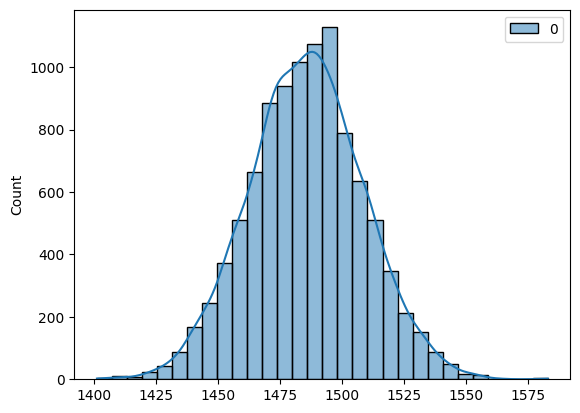

In [4]:
print('Average number of links: {:.2f}'.format(np.mean(LinkS)))
print('Standard deviation: {:.2f}'.format(np.std(LinkS)))

print('Expected number of links: {:.2f}'.format(Plink*Nnode*(Nnode-1)/2))
print('Expected standard deviation: {:.2f}'.format(np.sqrt(Plink*(1-Plink)*Nnode*(Nnode-1)/2)))

sns.histplot(data=LinkS, bins=30, kde=True)

The degree distribution for increasing size - CV decreases.
Tends to the delta function - regular graph.

In [5]:
Pow = 4.21 # max network size
Pl = 0.1
Cnt = 0

M = []
S = []
CV = []

In [8]:
for index in np.arange(2, Pow, step=0.3):
    Nnode = int(10**index)
    NetC = sp.sparse.triu(sp.sparse.rand(Nnode, Nnode, density=Pl, format='csr'), k=1)
    NetC = NetC + NetC.T
    K = sum(NetC).todense()
    M.append(np.mean(K))
    S.append(np.std(K))
    CV.append(np.std(K)/np.mean(K))
    # sns.histplot(data=K, bins=30, kde=True, label='N={:d}'.format(Nnode))
    # plt.show()
    print('N={:d} - Average degree: {:.2f}'.format(Nnode, M[Cnt]))
    print('N={:d} - Standard deviation: {:.2f}'.format(Nnode, S[Cnt]))
    print('N={:d} - CV: {:.2f}'.format(Nnode, CV[Cnt]))
    Cnt += 1

N=100 - Average degree: 9.82
N=100 - Standard deviation: 2.49
N=100 - CV: 0.25
N=199 - Average degree: 19.57
N=199 - Standard deviation: 3.40
N=199 - CV: 0.17
N=398 - Average degree: 4.78
N=398 - Standard deviation: 1.67
N=398 - CV: 0.35
N=794 - Average degree: 9.94
N=794 - Standard deviation: 2.54
N=794 - CV: 0.26
N=1584 - Average degree: 20.08
N=1584 - Standard deviation: 3.75
N=1584 - CV: 0.19
N=3162 - Average degree: 39.80
N=3162 - Standard deviation: 4.88
N=3162 - CV: 0.12
N=6309 - Average degree: 78.82
N=6309 - Standard deviation: 7.02
N=6309 - CV: 0.09
N=12589 - Average degree: 158.09
N=12589 - Standard deviation: 9.76
N=12589 - CV: 0.06


In [11]:
# sns.pairplot(data=CV, x_vars=np.arange(0, Nnode).all(), y_vars=CV, height=5, aspect=1, kind='reg')

## Giant component transition

In [14]:
Nnode = int(1e2)

rr = np.triu(np.random.rand(Nnode, Nnode), k=1)
rr = rr + rr.T

In [16]:
Pmin = 1 / (20 * Nnode)
Pmax = 1 / (6 * Nnode)
xP = np.arange(Pmin, Pmax, step=0.00002)

**NOTE** that $\lambda = xP * Nnode$

In [ ]:
# for index in xP:
#     Net = 